https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [2]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

### Load model and data

In [3]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=32, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### FGSM attack

In [4]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad, is_targeted=False):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    if is_targeted:
        sign_data_grad *= -1
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [34]:
def test(model, device, test_loader, epsilon, target_label=None):

    # Accuracy counter
    correct = 0
    total_succesful_attacks = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, labels in test_loader:

        # Send the data and label to the device
        data, labels = data.to(device), labels.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        
        hit_vector = init_pred.squeeze(1) == labels
#         relevant_targeted_attack_vector = init_pred.squeeze(1) != target_label
        relevant_targeted_attack_vector = labels != target_label
        if target_label:
            relevant_attack_idx = torch.nonzero(relevant_targeted_attack_vector & (init_pred.squeeze(1) != target_label)).flatten()
        else:
            relevant_attack_idx = torch.nonzero(hit_vector).flatten()        
        
        # If the initial prediction is wrong, don't bother attacking, just move on
#         if init_pred.item() != labels.item():
        if len(relevant_attack_idx) == 0:
            correct += hit_vector.sum().to(torch.device('cpu'))
            continue
    
        relevant_output = output[relevant_attack_idx]
        relevant_labels = labels[relevant_attack_idx]
    
        # Calculate the loss for the gradient
        if target_label:
            # Targeted attack
#             loss = F.nll_loss(relevant_output, torch.tensor([target_label]).to(device))
            loss = F.nll_loss(relevant_output, torch.tensor(target_label).expand(relevant_output.shape[0]).to(device))
        else:
            # Untargeted attack
            loss = F.nll_loss(relevant_output, relevant_labels)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()
       
        # Collect ``datagrad``
        data_grad = data.grad[relevant_attack_idx].data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data[relevant_attack_idx], epsilon, data_grad, is_targeted=bool(target_label))

        # Re-classify the perturbed image
        perturbed_output = model(perturbed_data)

        # Check for success
        perturbed_pred = perturbed_output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        correct_perturbed_classifications = perturbed_pred.flatten() == labels[relevant_attack_idx]
        
        # Unsuccessful attack
        if target_label:
            unsuccessful_attack_vector = perturbed_pred.flatten() != target_label
        else:
            unsuccessful_attack_vector = correct_perturbed_classifications
        
        num_unsuccessful_attacks = unsuccessful_attack_vector.sum()
        successful_attack_idx = torch.nonzero(~unsuccessful_attack_vector.flatten())
        num_successful_attacks = (~unsuccessful_attack_vector).sum()
        unsuccessful_attack_idx = torch.nonzero(unsuccessful_attack_vector.flatten())
        
        total_succesful_attacks += num_successful_attacks
        
        # Diff between unsuccessful attack and correct classification
        # In correct classification we also take into account unrelevant items and those who didn't reach the required target
        correct_batch_classifications = (~relevant_targeted_attack_vector & hit_vector).sum() + correct_perturbed_classifications.sum()

        correct += correct_batch_classifications.to(torch.device('cpu'))
        # Special case for saving 0 epsilon examples
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data[unsuccessful_attack_idx][0].squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred[unsuccessful_attack_idx][0].item(), perturbed_pred[unsuccessful_attack_idx][0].item(), adv_ex) )

        if num_successful_attacks and (epsilon != 0):
            # Save some adv examples for visualization later
#             if (len(adv_examples) < 5) and (not bool(target_label) or (target_label != labels.item())):
            if (len(adv_examples) < 5):
                adv_ex = perturbed_data[successful_attack_idx][0].squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred[successful_attack_idx][0].item(), perturbed_pred[successful_attack_idx][0].item(), adv_ex) )
                
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader) * test_loader.batch_size)
    succesful_attack_rate = total_succesful_attacks.item() / float(len(test_loader) * test_loader.batch_size)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader) * test_loader.batch_size, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, succesful_attack_rate, adv_examples


In [35]:
accuracies = []
total_succesful_attacks_list = []
examples = []

# Run test for each epsilon
for eps in tqdm(epsilons):
    acc, total_succesful_attacks, ex = test(model, device, test_loader, eps, target_label=9)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)
    examples.append(ex)

 14%|██████▍                                      | 1/7 [00:00<00:05,  1.01it/s]

Epsilon: 0	Test Accuracy = 9810 / 10016 = 0.9794328808784485


 29%|████████████▊                                | 2/7 [00:01<00:04,  1.02it/s]

Epsilon: 0.05	Test Accuracy = 9722 / 10016 = 0.9706469774246216


 43%|███████████████████▎                         | 3/7 [00:02<00:03,  1.03it/s]

Epsilon: 0.1	Test Accuracy = 9308 / 10016 = 0.9293131232261658


 57%|█████████████████████████▋                   | 4/7 [00:03<00:02,  1.04it/s]

Epsilon: 0.15	Test Accuracy = 8383 / 10016 = 0.8369608521461487


 71%|████████████████████████████████▏            | 5/7 [00:04<00:01,  1.03it/s]

Epsilon: 0.2	Test Accuracy = 6493 / 10016 = 0.6482627987861633


 86%|██████████████████████████████████████▌      | 6/7 [00:05<00:00,  1.03it/s]

Epsilon: 0.25	Test Accuracy = 4382 / 10016 = 0.4375


100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.03it/s]

Epsilon: 0.3	Test Accuracy = 2791 / 10016 = 0.27865415811538696


### Show results

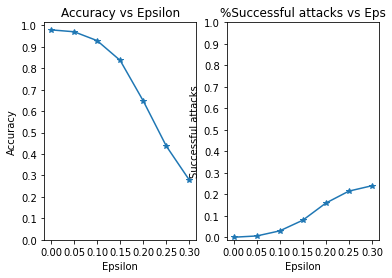

In [36]:
fig, ax = plt.subplots(1, 2)
_ = ax[0].plot(epsilons, accuracies, "*-")
_ = ax[0].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[0].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[0].set_title("Accuracy vs Epsilon")
_ = ax[0].set_xlabel("Epsilon")
_ = ax[0].set_ylabel("Accuracy")

_ = ax[1].plot(epsilons, total_succesful_attacks_list, "*-")
_ = ax[1].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[1].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[1].set_title("%Successful attacks vs Eps")
_ = ax[1].set_xlabel("Epsilon")
_ = ax[1].set_ylabel("Successful attacks")


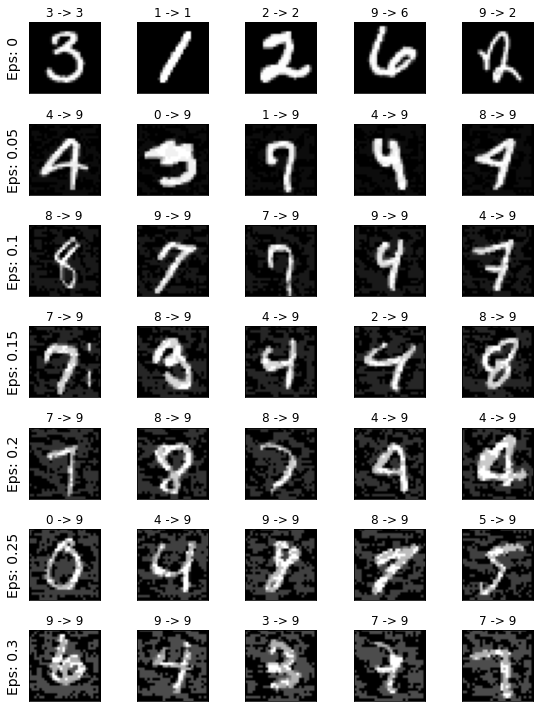

In [37]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()